This notebook runs the list-learning behavioral analyses

## Import libraries

In [1]:
import quail
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
from scipy.spatial.distance import cdist
%matplotlib inline

## Settings and parameters

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
datadir = '../../../data/processed/'
palette = 'bone'

## Load data

In [3]:
video_events = np.load(datadir+'video_events.npy')
recall_events = np.load(datadir+'recall_events.npy', allow_pickle=True)

## Convert to egg format

In [4]:
pres = [[[{'item' : i, 'topics' : m} for i, m in enumerate(video_events)]] for sub in range(17)]

rec = []
for r in recall_events:
    items = list(np.argmax(1 - cdist(video_events, r), 0).astype(int))
    rec.append([[{'item' : item, 'topics' : t} for item, t in zip(items, r)]])

## Make the egg

In [5]:
egg = quail.Egg(pres=pres, rec=rec)
egg.info()

Number of subjects: 17
Number of lists per subject: 1
Number of words per list: 36
Date created: Sun Aug 25 13:13:21 2019
Meta data: {}


## Run probability of first recall, lagcrp and serial position curve analyses, and create a figure

/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/quail/quail/analysis/recmat.py:93: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  lists = presented.index.get_values()
/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/quail/quail/analysis/recmat.py:100: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  p = np.vstack(p_list.apply(get_feature).get_values())
/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/quail/quail/analysis/recmat.py:101: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  r = r_list.dropna().apply(get_feature).get_values()
/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/quail/quail/analysis/recmat.py:106: RuntimeWarning: Mean of empty slice
  return np.nanmean(res, 1)
/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/p

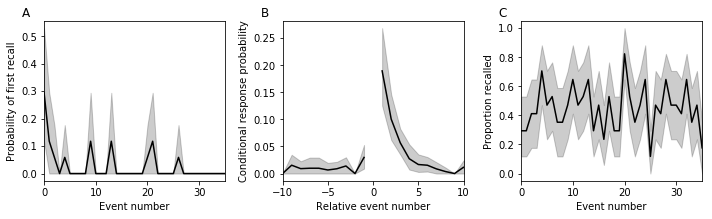

In [6]:
fig, axarr = plt.subplots(1, 3)
fig.set_size_inches(10, 3)

analysis = ['pfr', 'lagcrp', 'spc']
res = {}
for ax, a in zip(axarr, analysis):
    res[a] = egg.analyze(a, match='best', features=['topics'], 
                distance='correlation')
    res[a].plot(show=False, ax=ax, legend=False, palette=palette)
        
# make some adjustments
axarr[1].set_xlim(-10, 10)
axarr[0].set_ylabel('Probability of first recall')
axarr[1].set_ylabel('Conditional response probability')
axarr[2].set_ylabel('Proportion recalled')
axarr[0].set_xlabel('Event number')
axarr[1].set_xlabel('Relative event number')
axarr[2].set_xlabel('Event number')
plt.subplots_adjust(wspace=.45, hspace=.75)
plt.tight_layout()

# add labels
label=['A', 'B', 'C']
for p, l in zip(axarr, label):
    p.text(-.1,1.025,l,
        horizontalalignment='center',
        transform=p.transAxes,
          fontsize=12)
# plt.savefig('../figures/list_learning.pdf')
# plt.savefig('/Users/paxtonfitzpatrick/Desktop/sherlock-list-learning.pdf')
plt.show()

## Cluster analyses

In [13]:
from scipy.stats import pearsonr

/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


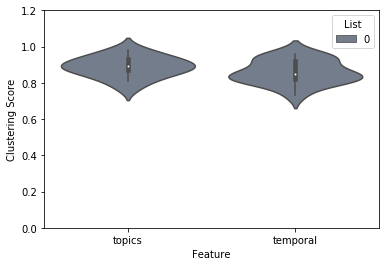

In [7]:
clustering = egg.analyze('fingerprint')
clustering.plot(ylim=[0, 1.2], palette=palette)

## SEM of clustering scores

In [8]:
sem = clustering.get_data().std() / np.sqrt(17)
print(clustering.get_data().mean())
print(sem)
print(clustering.get_data().mean() + sem)
clustering.get_data().mean() - sem

topics      0.888761
temporal    0.860288
dtype: float64
topics      0.013821
temporal    0.015666
dtype: float64
topics      0.902582
temporal    0.875955
dtype: float64


topics      0.874940
temporal    0.844622
dtype: float64

## Create a dataframe containing the analysis results

In [10]:
recall_events[0].shape

(17, 100)

In [11]:
# ks = np.array([8, 14, 11, 9, 14, 10, 17, 17, 10, 20, 19, 25, 27, 14, 10, 14, 23])
ks = np.array([r.shape[0] for r in recall_events])
hand_rec = np.array([27, 24, 32, 33, 32, 39, 30, 39, 28, 40, 34, 38, 47, 38, 27, 37, 39])
auto_rec = res['spc'].data.mean(1).values
df = pd.DataFrame(np.array([clustering.data.temporal.values, clustering.data.topics.values, ks, hand_rec, auto_rec]).T, 
                  columns=['Temporal clustering', 'Semantic clustering', 'Number of events (k)', 'Memory performance - hand', 
                           'Memory performance - auto'])

## Correlation between hand annotated memory and memory estimated from the model across subjects

/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


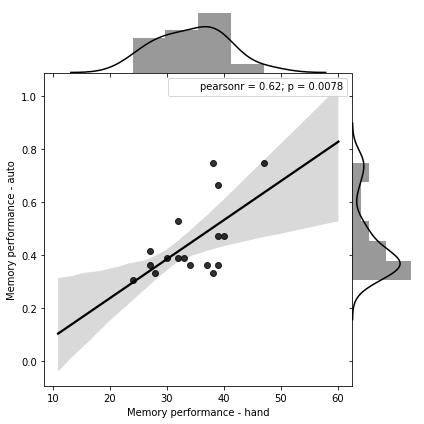

In [15]:
sns.jointplot(x=df['Memory performance - hand'], y=df['Memory performance - auto'], kind='reg', stat_func=pearsonr,
              space=False, color='k')

## Correlation between hand annotated memory and k (number of events) across subjects

/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


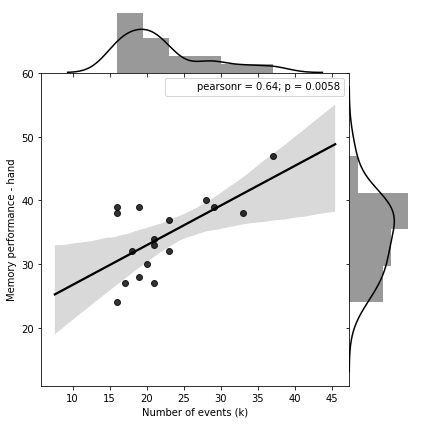

In [16]:
sns.jointplot(y=df['Memory performance - hand'], x=df['Number of events (k)'], kind='reg', stat_func=pearsonr,
              space=False, color='k')

## Correlation between hand annotated memory and temporal clustering

/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


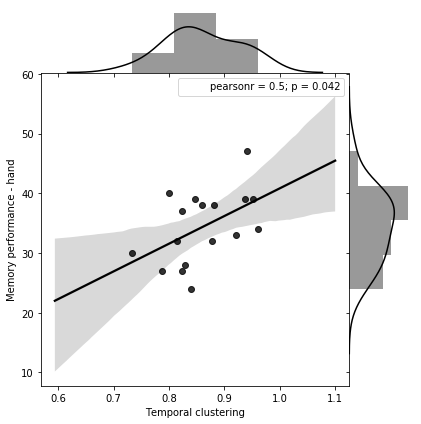

In [17]:
sns.jointplot(y=df['Memory performance - hand'], x=df['Temporal clustering'], kind='reg', stat_func=pearsonr,
              space=False, color='k')

## Correlation between hand annotated memory and semantic clustering

/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


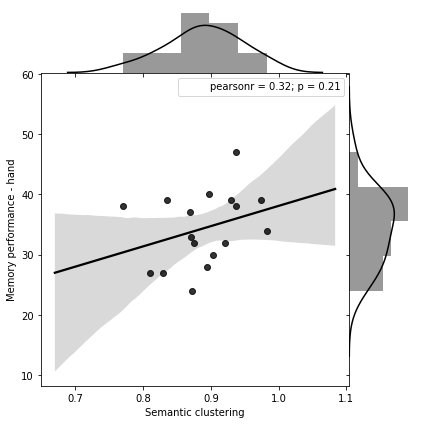

In [18]:
sns.jointplot(y=df['Memory performance - hand'], x=df['Semantic clustering'], kind='reg', stat_func=pearsonr,
              space=False, color='k')